In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/continuous dataset.csv
/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv


## Load Data

In [2]:
import pandas as pd
df= pd.read_csv('../input/electricity-load-forecasting/continuous dataset.csv', index_col=[0], parse_dates=[0])
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


<Axes: xlabel='datetime'>

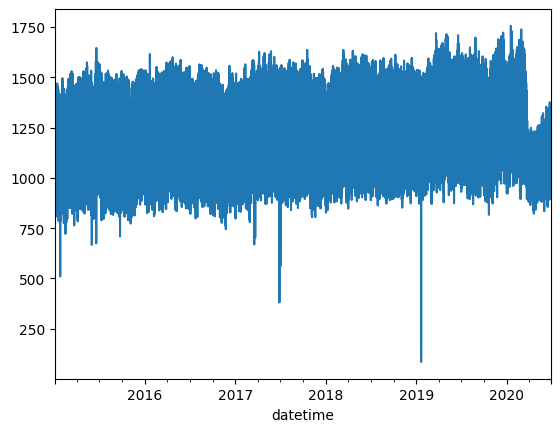

In [3]:
df['nat_demand'].plot()

## Generate Time-Series Data

In [4]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

def create_timeseries_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Use isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_timeseries_features(df, label='nat_demand')
features_and_target = pd.concat([X, y], axis=1)

In [5]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,nat_demand
datetime,,,,,,,,,,,
2015-01-03 01:00:00,1,5,1,1,2015,3,3,1,Saturday,Winter,970.3450
2015-01-03 02:00:00,2,5,1,1,2015,3,3,1,Saturday,Winter,912.1755
2015-01-03 03:00:00,3,5,1,1,2015,3,3,1,Saturday,Winter,900.2688
2015-01-03 04:00:00,4,5,1,1,2015,3,3,1,Saturday,Winter,889.9538
2015-01-03 05:00:00,5,5,1,1,2015,3,3,1,Saturday,Winter,893.6865


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)})

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


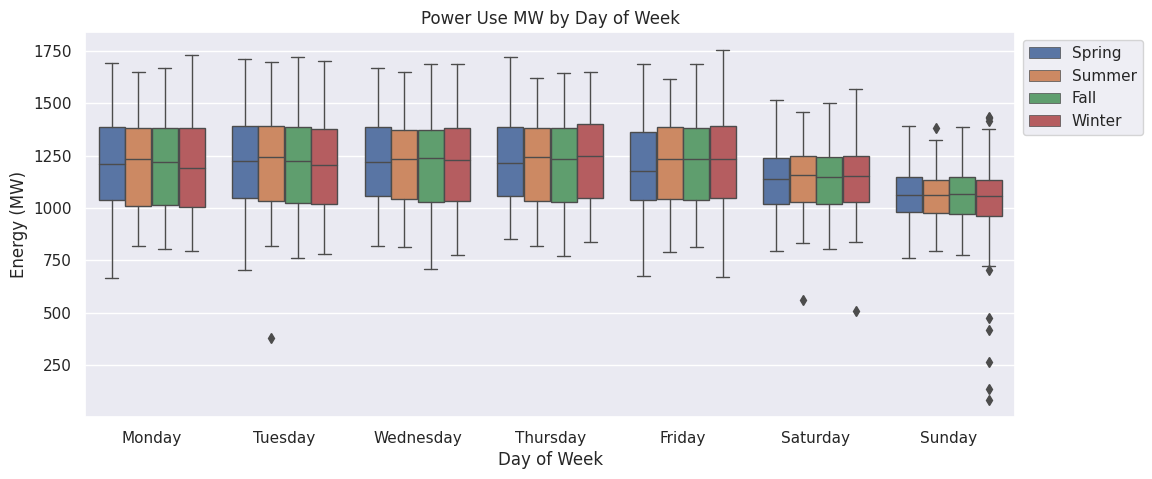

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=features_and_target.dropna(), x='weekday', y='nat_demand', hue='season', ax=ax, linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


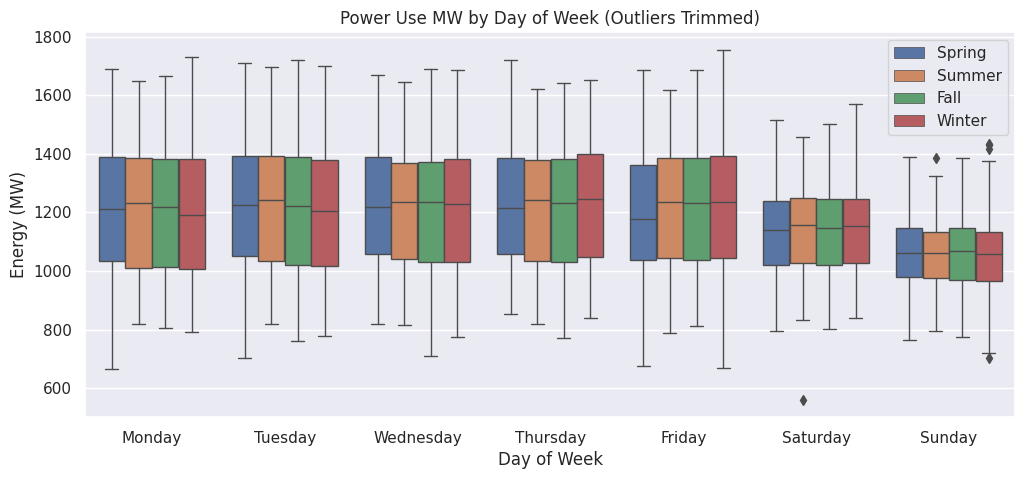

In [8]:
import pandas

#Calculate the lower and upper bounds for outliers
Q1 = df['nat_demand'].quantile(0.25)
Q3 = df['nat_demand'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

#Filter the DataFrame from target and exclude outliers
filtered_df = features_and_target[(features_and_target['nat_demand'] >= lower_bound) & (features_and_target['nat_demand'] <= upper_bound)]

# Create the boxplot with trimmed outliers
fig, ax = plt.subplots(figsize = (12, 5))
sns.boxplot(data=filtered_df.dropna(), x='weekday', y='nat_demand', hue='season', ax=ax, linewidth=1)
ax.set_title('Power Use MW by Day of Week (Outliers Trimmed)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [9]:
X.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
datetime,,,,,,,,,,
2015-01-03 01:00:00,1,5,1,1,2015,3,3,1,Saturday,Winter
2015-01-03 02:00:00,2,5,1,1,2015,3,3,1,Saturday,Winter
2015-01-03 03:00:00,3,5,1,1,2015,3,3,1,Saturday,Winter
2015-01-03 04:00:00,4,5,1,1,2015,3,3,1,Saturday,Winter
2015-01-03 05:00:00,5,5,1,1,2015,3,3,1,Saturday,Winter


In [10]:
y.head()

datetime
2015-01-03 01:00:00    970.3450
2015-01-03 02:00:00    912.1755
2015-01-03 03:00:00    900.2688
2015-01-03 04:00:00    889.9538
2015-01-03 05:00:00    893.6865
Name: nat_demand, dtype: float64

In [11]:
file_path = 'features_and_target.csv'
filtered_df.to_csv(file_path, index=False)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [13]:
df1 = filtered_df
df1.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,nat_demand
datetime,,,,,,,,,,,
2015-01-03 01:00:00,1,5,1,1,2015,3,3,1,Saturday,Winter,970.3450
2015-01-03 02:00:00,2,5,1,1,2015,3,3,1,Saturday,Winter,912.1755
2015-01-03 03:00:00,3,5,1,1,2015,3,3,1,Saturday,Winter,900.2688
2015-01-03 04:00:00,4,5,1,1,2015,3,3,1,Saturday,Winter,889.9538
2015-01-03 05:00:00,5,5,1,1,2015,3,3,1,Saturday,Winter,893.6865


In [14]:
# Assuming df1 is your DataFrame
# First, convert categorical variables to one-hot encoding
df1 = pd.get_dummies(df1, columns=['weekday', 'season'])
X = df1.drop('nat_demand', axis = 1)
y = df1['nat_demand']
# Now, perform MinMax scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [15]:
X

array([[0.04347826, 0.83333333, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.08695652, 0.83333333, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.13043478, 0.83333333, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.95652174, 0.66666667, 0.33333333, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.66666667, 0.33333333, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.83333333, 0.33333333, ..., 1.        , 0.        ,
        0.        ]])

In [16]:
y

datetime
2015-01-03 01:00:00     970.3450
2015-01-03 02:00:00     912.1755
2015-01-03 03:00:00     900.2688
2015-01-03 04:00:00     889.9538
2015-01-03 05:00:00     893.6865
                         ...    
2020-06-26 20:00:00    1128.5592
2020-06-26 21:00:00    1112.7488
2020-06-26 22:00:00    1081.5680
2020-06-26 23:00:00    1041.6240
2020-06-27 00:00:00    1013.5683
Name: nat_demand, Length: 48041, dtype: float64

## Initialize models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Initialise model
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor())
]

for name, model in models:
    model.fit(X_train, y_train)
    
    #Make predictions & evaluate model
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    print(f"Model: {name}")
    print(f"RMSE: {rmse}")
    print(f'R-squared score: {r2}')
    print('-'*20)
    

Model: Linear Regression
RMSE: 170.9179351109396
R-squared score: 0.1552388909921678
--------------------
Model: Decision Tree
RMSE: 144.48172312070636
R-squared score: 0.3963510328801284
--------------------
Model: Random Forest
RMSE: 134.88411062324164
R-squared score: 0.47388555943827415
--------------------
Model: Gradient Boosting
RMSE: 127.29416365578132
R-squared score: 0.5314287686170026
--------------------
Model: SVR
RMSE: 165.65802749486647
R-squared score: 0.20643298360725137
--------------------
Model: KNN
RMSE: 144.4713124990982
R-squared score: 0.3964380215238891
--------------------


In [18]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import HuberRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

#Split the data inot training and testing sets
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Initialise models
models = [
    ("Lasso Regression", Lasso()),
    ("Ridge Regression", Ridge()),
    ("ElasticNet", ElasticNet()),
    ("Huber Regression", HuberRegressor()),
    ("Bayesian Regression", BayesianRidge()),
]

for name, model in models:
    model.fit(X_train, y_train)

    # Make predictions and evaluate each model
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    print(f"Model: {name}")
    print('Root Mean Squared Error (RMSE):', rmse)
    print('R-squared (R2) Score:', r2)
    print('-'*20)

Model: Lasso Regression
Root Mean Squared Error (RMSE): 170.60616179784125
R-squared (R2) Score: 0.158317956484766
--------------------
Model: Ridge Regression
Root Mean Squared Error (RMSE): 174.10043071271093
R-squared (R2) Score: 0.12348706814718724
--------------------
Model: ElasticNet
Root Mean Squared Error (RMSE): 181.0937999437399
R-squared (R2) Score: 0.05165621935602005
--------------------
Model: Huber Regression
Root Mean Squared Error (RMSE): 171.22491580100393
R-squared (R2) Score: 0.1522016646023211
--------------------
Model: Bayesian Regression
Root Mean Squared Error (RMSE): 174.206936970729
R-squared (R2) Score: 0.12241432333123636
--------------------


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

#Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

#Create the GradientBoostingRegressor model
model = GradientBoostingRegressor()

#Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

#Get the best hyp and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#Make predictions & evaluate best model
predictions = best_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print("Best Hyp: ", best_params)
print("RMSE: ", rmse)
print('R2 score: ', r2)

Best Hyp:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}
RMSE:  127.5938217235444
R2 score:  0.5292200826272158


**This is the best model after all experiments**